In [1]:
from pyspark.sql import SparkSession
from pyspark import SparkContext

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Create a Spark session
spark = SparkSession.builder.appName("MySparkApp").getOrCreate()
sc = SparkContext.getOrCreate()
spark.sparkContext.setLogLevel("ERROR")

23/12/16 20:32:10 WARN Utils: Your hostname, MacBook-Pro-di-Luca-2.local resolves to a loopback address: 127.0.0.1; using 192.168.1.155 instead (on interface en0)
23/12/16 20:32:10 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/12/16 20:32:11 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
# ReadFile function
def readFile(filename):

    # Read the file into an RDD
    # Each line in the file becomes one record in the RDD
    lines = sc.textFile(filename)

    # Process each line in the RDD, each element in data ends in a tuple containing a list of the first 11 features, and a number representing the target
    data = lines.map(lambda line: line.split(','))\
                .map(lambda elem: ([float(x) for x in elem[:-1]], int(elem[-1])))

    return data

In [3]:
#Testing of the read function
filename = 'data/botnet_tot_syn_l.csv'
RDD_Xy = readFile(filename).map( lambda x: (np.array(x[0]), x[1]))

# Printing first 5 rows of the RDD
for row in RDD_Xy.take(5):
    print(row)

(array([9.01278427e+00, 1.67299998e+03, 2.19999885e+01, 9.99999745e-01,
       6.19998877e+01, 6.99998079e+01, 1.30000002e+01, 2.99999998e+00,
       1.99000002e+02, 2.46836957e+09, 2.46837255e+09]), 1)
(array([3.59999909e+03, 4.82065758e+04, 1.33629998e+04, 1.00000192e+00,
       2.62999242e+02, 8.29998876e+01, 1.39999452e+01, 5.00000003e+00,
       2.16999996e+02, 1.53904420e+09, 2.46836839e+09]), 0)
(array([6.99938676e-04, 9.47284469e-04, 5.30002602e+01, 2.00000042e+00,
       6.46242903e+08, 8.29998876e+01, 1.30000000e+01, 2.99999999e+00,
       2.16999996e+02, 2.46836954e+09, 2.50325008e+09]), 0)
(array([3.59999909e+03, 1.71877436e+03, 6.33776887e+04, 1.00000192e+00,
       9.26682197e+05, 5.43556891e+02, 1.30000000e+01, 5.00000003e+00,
       1.86999994e+02, 4.05749205e+08, 1.12542449e+09]), 0)
(array([ 3.47137922e+03,  4.80241859e+04,  3.50889376e-04,  5.07008976e+05,
        2.62999242e+02,  1.00012368e+03,  1.30000000e+01, -7.71042474e-09,
        7.99999924e+00,  4.61400457e+

In [4]:
'''
def compute_stats(RDD):
    # Calculate sum and sum of squares for each feature
    sums = RDD.map(lambda x: x[0]).reduce(lambda a, b: [a[i] + b[i] for i in range(len(a))])
    return sums
print(compute_stats(rdd))
'''

'\ndef compute_stats(RDD):\n    # Calculate sum and sum of squares for each feature\n    sums = RDD.map(lambda x: x[0]).reduce(lambda a, b: [a[i] + b[i] for i in range(len(a))])\n    return sums\nprint(compute_stats(rdd))\n'

In [5]:
# Function that computes the means and std devs
def compute_mean_stds(RDD):

    # Calculate sum and sum of squares for each feature
    sums = RDD.map(lambda x: x[0]).reduce(lambda a, b: a+b)
    sum_of_squares = RDD.map(lambda x: x[0]**2).reduce(lambda a, b: a+b)
    count = RDD.count()

    # Compute mean and standard deviation for each feature
    means = sums / count
    stds = ((sum_of_squares / count) - means ** 2) ** 0.5 
    
    return means, stds


# Normalize function
def normalize(RDD_Xy):
    # Compute means and standard deviations
    means, stds = compute_mean_stds(RDD_Xy)

    # normalized_RDD = RDD_Xy.map(lambda x: ([(x[0][i] - means[i]) / stds[i] if stds[i] != 0 else 0 for i in range(len(x[0]))], x[1]))
    normalized_RDD = RDD_Xy.map(lambda x: ((x[0] - means) / stds , x[1]))

    return normalized_RDD



In [6]:
#Testing of the normalize function
normalized_RDD = normalize(RDD_Xy)

# Print first 5 normalized rows
for row in normalized_RDD.take(5):
    print(row)


(array([-0.79240977, -0.81309371, -0.42245076, -0.46646975, -0.52239296,
       -0.35631957,  0.7370103 ,  0.52834963,  0.82717799,  0.47316616,
        0.15895172]), 1)
(array([ 1.4437204 ,  1.116361  ,  0.39127564, -0.46646975, -0.5223921 ,
       -0.35631927,  0.92633194,  1.48012075,  1.02641833, -0.82869545,
        0.15894853]), 0)
(array([-0.79802166, -0.88246246, -0.42055992, -0.4664623 ,  2.24026466,
       -0.35631927,  0.73701025,  0.52834964,  1.02641833,  0.47316612,
        0.18574901]), 0)
(array([ 1.4437204 , -0.81119573,  3.44189202, -0.46646975, -0.5184317 ,
       -0.35630884,  0.73701025,  1.48012075,  0.69435097, -2.41629145,
       -0.87286932]), 0)
(array([ 1.36362799,  1.10879844, -0.42379262,  3.30972605, -0.5223921 ,
       -0.35629849,  0.73701025, -0.89930699, -1.28698408, -2.33833143,
       -1.73756142]), 0)


In [7]:
# Sigmoid function
def sigmoid(z):
    return 1 / (1 + np.exp(-z))


# Function that computes the value z, which is indeed a linear combination of weights and features + the bias
def linear_combination(features, weights, bias):
    return sum(weights[j] * features[j] for j in range(len(weights))) + bias


# Function to compute the gradient of each record (row) of the dataset
def compute_gradients_and_cost(record, weights, bias):
    xi, yi = record

    y_hat = sigmoid(linear_combination(xi, weights, bias))
    error = y_hat - yi
    dw = np.zeros(len(weights))

    for j in range(len(weights)):
        dw[j] = error * xi[j]
    
    db = error
    cost_contribution = -yi * np.log(y_hat) - (1 - yi) * np.log(1 - y_hat)
    
    return (dw, db, cost_contribution)


# Actual train function
def train(RDD_Xy, iterations, learning_rate, lambda_reg):
    np.random.seed(0) 
    feature_count = len(RDD_Xy.first()[0])
    w = np.random.rand(feature_count)
    b = np.random.rand()
    m = RDD_Xy.count()

    for n in range(iterations):
        
        gradients_and_cost = RDD_Xy.map(lambda x: compute_gradients_and_cost(x, w, b))
        dw, db, total_cost = gradients_and_cost.reduce(lambda a, b: (a[0] + b[0], a[1] + b[1], a[2] + b[2]))
        
        reg_cost = (lambda_reg / (2 * feature_count)) * np.sum(np.square(w))
        cost = (total_cost / m) + reg_cost
        
        # Update weights and bias
        w -= learning_rate * ((dw / m) + (lambda_reg/m) * w)
        b -= learning_rate * db / m


        print(f"Iteration {n+1}/{iterations} - Cost: {cost}")

    return w, b


In [8]:
w, b = train(normalized_RDD, 10, 1.5, 0)


Iteration 1/10 - Cost: 1.4998030671352984


Iteration 2/10 - Cost: 0.7452491273041107


Iteration 3/10 - Cost: 0.4463838653243955


Iteration 4/10 - Cost: 0.33598210709531867


Iteration 5/10 - Cost: 0.2858186861976214


Iteration 6/10 - Cost: 0.2581741737711223


Iteration 7/10 - Cost: 0.24076133573757508


Iteration 8/10 - Cost: 0.22876056610476408


Iteration 9/10 - Cost: 0.21995387544017125


Iteration 10/10 - Cost: 0.21318893422096608


In [9]:
# Predict function
def predict(w, b, x, trashold=0.5):
    z = 0
    for j in range(len(w)):
        z += w[j] * x[j]

    z+= b
    # Compute the sigmoid of z
    y_hat = sigmoid(z)

    if y_hat > trashold:
        return 1
    else: 
        return 0


In [10]:
# Accuracy function
def accuracy(w, b, RDD_Xy):
    
    results = RDD_Xy.map(lambda r: 1 if predict(w, b, r[0]) == r[1] else 0)
    results = results.reduce( lambda a, b: a + b)

    accuracy = results / RDD_Xy.count()
    return accuracy


In [11]:
acc = accuracy(w, b, normalized_RDD)

print("Accuracy: ", acc)

Accuracy:  0.930181


In [12]:
def compute_metrics(RDD_Xy, w, b):
    thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

    def calculate_metrics_for_threshold(RDD, threshold):
        # Calculate TP, FP, TN, FN for a given threshold
        metrics = RDD.map(lambda x: (predict(w, b, x[0], threshold), x[1])) \
                     .map(lambda x: (int(x[0] == 1 and x[1] == 1), int(x[0] == 1 and x[1] == 0), int(x[0] == 0 and x[1] == 0), int(x[0] == 0 and x[1] == 1))) \
                     .reduce(lambda a, b: (a[0] + b[0], a[1] + b[1], a[2] + b[2], a[3] + b[3]))
        TP, FP, TN, FN = metrics

        return TP, FP, TN, FN

    # Compute metrics for each threshold
    metrics_for_thresholds = {thresh: calculate_metrics_for_threshold(RDD_Xy, thresh) for thresh in thresholds}
    return metrics_for_thresholds

accuracy: [0.777585 0.858916 0.897581 0.919363 0.930181 0.931607 0.918127 0.8758
 0.774564]
precision: [0.6927928  0.78373883 0.84052355 0.8827555  0.91533445 0.94195312
 0.96296928 0.98013533 0.99250915]
recall: [0.99749  0.991392 0.98136  0.967184 0.948054 0.919902 0.869698 0.767148
 0.553304]
F1: [0.81767843 0.87541988 0.90549826 0.92304315 0.93140696 0.93079698
 0.91396018 0.86066048 0.71051185]


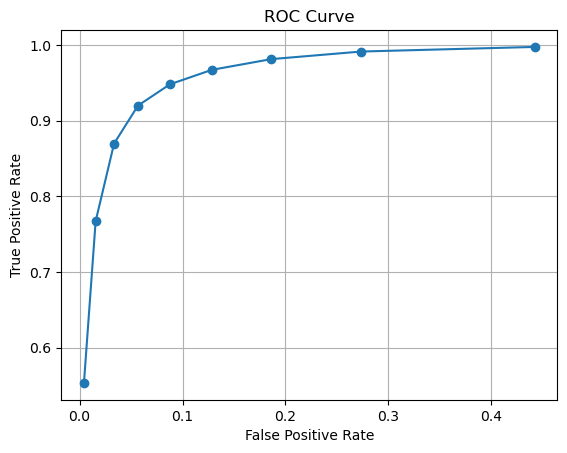

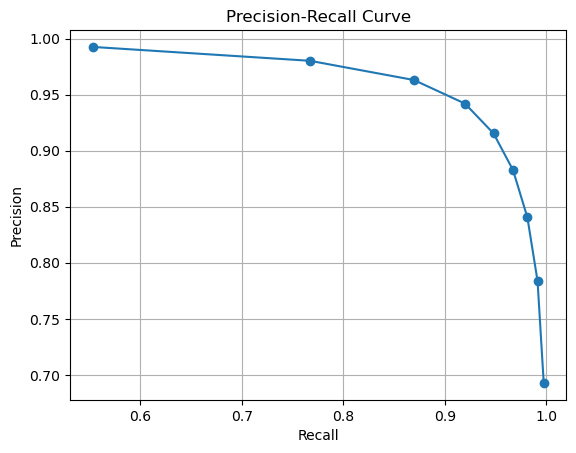

In [13]:
metrics_for_thresholds = compute_metrics(normalized_RDD, w, b)

TP = []
FP = []
TN = []
FN = []

for threshold, metrics in metrics_for_thresholds.items():
    TP.append(metrics[0])
    FP.append(metrics[1])
    TN.append(metrics[2])
    FN.append(metrics[3])

TP = np.array(TP)
FP = np.array(FP)
TN = np.array(TN)
FN = np.array(FN)
#Accuracy
accuracy = (TP + TN) / (TP + FP + TN + FN)
print("accuracy:", accuracy)
#Precision
precision = TP / (TP + FP)
print("precision:", precision)
#Recall
recall = TP / (TP + FN)
print("recall:", recall)
#F1
F1 = 2 * precision * recall / (precision + recall)
print("F1:", F1)
#ROC
TPR = TP / (TP + FN)
FPR = FP / (FP + TN)
plt.plot(FPR, TPR, marker='o')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)
plt.show()
#Precision-Recall
plt.plot(recall, precision, marker='o')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid(True)
plt.show()